# Random Forrest analysis to predict age of manure using microbiome profile

(1) I downloaded and loaded the require R package 

In [17]:
#install require packages
install.packages("colorRamps")
install.packages("RColorBrewer")
install.packages("randomForest")
install.packages("e1071")
install.packages("pROC")
install.packages("dplyr")
install.packages("ggplot2")

also installing the dependencies ‘bindr’, ‘bindrcpp’, ‘glue’, ‘pkgconfig’, ‘rlang’, ‘tibble’, ‘plogr’



In [32]:
#load the packages
library("car")
library("colorRamps")
library("RColorBrewer")
library(randomForest)
library(e1071)
library(pROC)
library("dplyr")
library("ggplot2")
library("data.table")


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



(2) upload the datafile and then assign four different periods according to the days of manure. 

In [12]:
#Load the dataset and clean the 
class.abun <- read.csv("~/Dropbox/EPA_transfer_files/Rarefaction curve_2/NMDS.csv")
class.abun[is.na(class.abun)] <- 0 #change na to 0
class.abun$period <- class.abun$Day #create period column

#group day to period
class.abun <- read.csv("~/Dropbox/EPA_transfer_files/Rarefaction curve_2/NMDS.csv")
class.abun[is.na(class.abun)] <- 0 #change na to 0
class.abun$period[class.abun$Day == 0] <- "period1"
class.abun$period[class.abun$Day >0 & class.abun$Day < 22] <- "period2"
class.abun$period[class.abun$Day >=22 & class.abun$Day <=29] <- "period3"
class.abun$period[class.abun$Day >=43 & class.abun$Day <=57] <- "period4"
class.abun$period <- as.factor(class.abun$period)#covert class.abun$period to factor
class.abun <- droplevels(class.abun)

(3) split the data between training and testing set. Then, run the random forest model and calcuate accuracy and ROC curves 

In [107]:
set.seed(42)

#random forest model
#prepare train and test data
num.total = 79
num.train = 60

s <- sample(num.total, num.train)
class.train <- class.abun[s, 3:18]
class.test <- class.abun[-s, 3:18]

rfm <- randomForest(period ~., class.train) #create model using train data
p <- predict(rfm, class.test) #predict using test data
mean(class.test$period==p) #accuracy
table(class.test$period, p) #accuracy table

p <- as.numeric(predict(rfm, class.test, type = 'response'))#prediction and convert to numeric for ROC analysis
multiclass.roc(as.numeric(class.test$period), p)#calculate average area under multiple ROC curves

importance(rfm)

[1] 0.7894737

         p
          period1 period2 period3 period4
  period1       2       0       0       0
  period2       0       9       1       1
  period3       0       1       1       0
  period4       0       0       1       3


Call:
multiclass.roc.default(response = as.numeric(class.test$period),     predictor = p)

Data: p with 4 levels of as.numeric(class.test$period): 1, 2, 3, 4.
Multi-class area under the curve: 0.9176

,MeanDecreaseGini
Actinobacteria,4.565056
Bacteroidia,4.221028
Flavobacteria,2.413677
Sphingobacteria,1.533641
Unclassified.Bacteroidetes,1.266017
Bacilli,1.841608
Clostridia,5.452743
Unclassified.Firmicutes,4.029616
Alphaproteobacteria,2.481050
Betaproteobacteria,2.652066


(4) 

In [108]:
set.seed(42)

# Iteration over number of random forest and training data set
x =500 # x = number of iteration 
division <- 60 # division = number of training data 

acc.list <- rep(0,x)
average.acc.list <- c()
sd.average.acc.list <- c()

roc.list <- rep(0,x)
average.roc.list <- c()
sd.average.roc.list <- c()

#Select abundance data from the follwing bacteria for analysis 
m <- c("Actinobacteria", "Bacteroidia", "Flavobacteria", "Sphingobacteria", 
       "Unclassified.Bacteroidetes", "Bacilli" ,"Clostridia" ,"Unclassified.Firmicutes",   
      "Alphaproteobacteria", "Betaproteobacteria", "Deltaproteobacteria", "Gammaproteobacteria",
      "Unclassified.Proteobacteria", "Others", "Unclassified")
m <- data.frame(names = m, MeanDecreaseGini=c(rep(0, 15)))

  
for (j in division){
   for (i in 1:x){
      s <- sample(79, j)
      class.train <- class.abun[s, 3:18]
      class.test <- class.abun[-s, 3:18]
      rfm <- randomForest(period ~., class.train) #create model using train data
      
      p <- predict(rfm, class.test) #predict using test data
      acc = mean(class.test$period==p) #calculate accuracy
      acc.list[i] = acc
      
      p <- as.numeric(predict(rfm, class.test, type = 'response')) #prediction and convert to numeric for ROC analysis
      roc = as.numeric(multiclass.roc(as.numeric(class.test$period), p)[7]) #calculate ROC
      roc.list[i] = roc
       
      s[[i]] <- as.data.frame(importance(rfm), stringsAsFactors = FALSE)
      names <- rownames(s[[i]])
      rownames(s[[i]]) <- NULL
      s[[i]] <- cbind(names,s[[i]])
      m <- full_join(m, s[[i]], by="names")   
   }
  average.acc = sum(acc.list)/x
  average.acc.list = append(average.acc.list, average.acc)
  sd.average.acc.list = append(sd.average.acc.list, sd(acc.list))

  average.roc = sum(roc.list)/x
  average.roc.list = append(average.roc.list, average.roc)
  sd.average.roc.list = append(sd.average.roc.list, sd(roc.list))
    
}


m$mean <- rowMeans(m[, 3:(x+2)])
m$std <- m[, 3:(x+2)] %>% apply(1, sd, na.rm = TRUE) 
importance.table = select(m, names, mean, std)

In [109]:
sprintf("The average ACC is: %f", average.acc.list)
sprintf("The standard deviation of ACC is: %f ", sd.average.acc.list)

sprintf("The average ROC is: %f", average.roc.list)
sprintf("The standard deviation of ROC is: %f ", sd.average.roc.list)

[1] "The average ACC is: 0.769684"

[1] "The standard deviation of ACC is: 0.092380 "

[1] "The average ROC is: 0.919448"

[1] "The standard deviation of ROC is: 0.044773 "

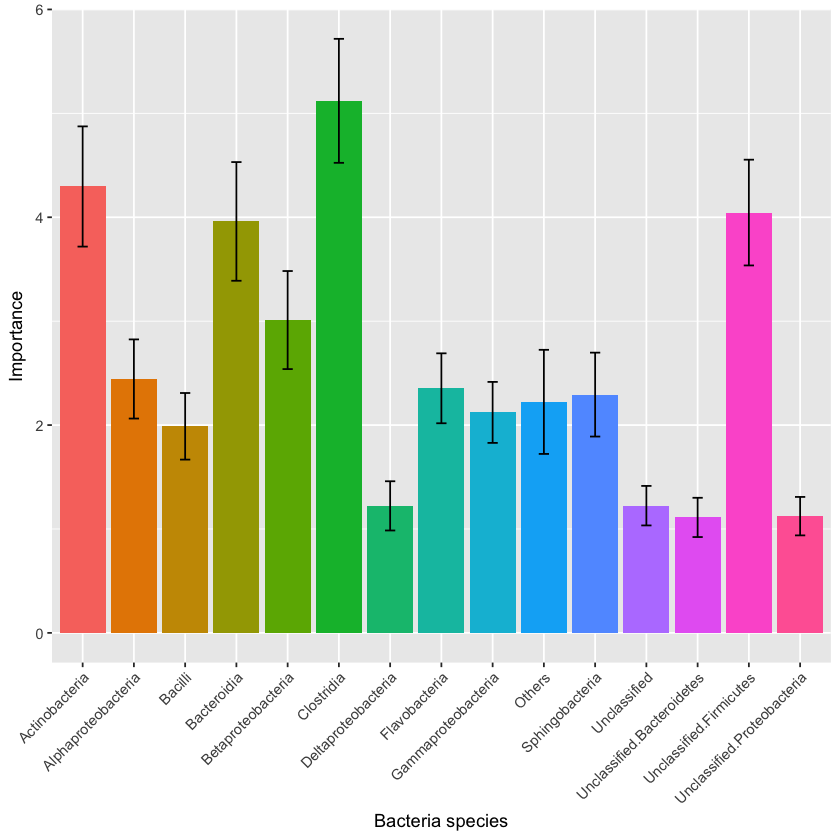

In [110]:
importance.table2 <- importance.table
importance.table2 <- importance.table2[order(importance.table2$names), ] 

# Error bars represent standard error of the mean
ggplot(importance.table2, aes(x=names, y=mean, fill = names)) + 
    geom_bar(position=position_dodge(), stat="identity") +
    geom_errorbar(aes(ymin=mean-std, ymax=mean+std),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    theme(legend.position="none") +
    labs(x = "Bacteria species", y = "Importance") 